In [1]:
import pennylane as qml
import numpy as np
from qiskit import IBMQ
import itertools
import matplotlib.pyplot as plt

In [2]:
seed = 2

weights = qml.init.basic_entangler_layers_uniform(n_layers=1, n_wires=5, seed=seed).flatten()
weights

tensor([2.73943676, 0.16289932, 3.4536312 , 2.73521126, 2.6412488 ], requires_grad=True)

In [3]:
datafile_hw = "results_hw.pickle"
datafile_sim = "results_sim.pickle"

In [4]:
import pickle

In [5]:
s = 0.5 * np.pi
denom = 4 * np.sin(s) ** 2
shift = np.eye(len(weights))

def get_hess(weights, file):
    hess = np.zeros((len(weights), len(weights)))
    
    with open(file, "rb") as f:
        results = pickle.load(f)
    
    for c in itertools.combinations(range(len(weights)), r=2):
        r = results.get(c)
        if r:
            hess[c] = (r[0] - r[1] - r[2] + r[3]) / denom
    
    hess = hess + hess.T
    
    for i in range(len(weights)):
        r = results.get((i, i))
        if r:
            hess[i, i] = (r[0] + r[1] - 2 * r[2]) / 2
    
    return hess    

In [6]:
hess_hw = get_hess(weights, datafile_hw)
np.around(hess_hw, 3)

array([[ 0.695,  0.085,  0.026, -0.138, -0.003],
       [ 0.085,  0.596, -0.02 ,  0.058,  0.001],
       [ 0.026, -0.02 ,  0.665,  0.096, -0.028],
       [-0.138,  0.058,  0.096,  0.691, -0.012],
       [-0.003,  0.001, -0.028, -0.012,  0.012]])

In [7]:
hess_sim = get_hess(weights, datafile_sim)
np.around(hess_sim, 3)

array([[ 0.794,  0.055,  0.109, -0.145,  0.   ],
       [ 0.055,  0.794, -0.042,  0.056, -0.   ],
       [ 0.109, -0.042,  0.794,  0.11 ,  0.   ],
       [-0.145,  0.056,  0.11 ,  0.794,  0.   ],
       [ 0.   , -0.   ,  0.   ,  0.   , -0.   ]])

In [8]:
hess_hw_4 = hess_hw[:4, :4]
hess_sim_4 = hess_sim[:4, :4]

rel = np.abs((hess_hw_4 - hess_sim_4) / hess_sim_4)
mse = np.abs(hess_hw - hess_sim)

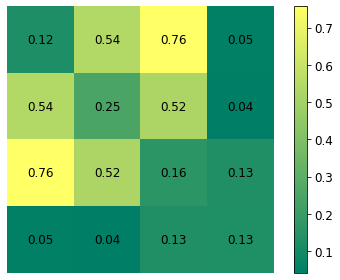

In [10]:
import matplotlib.cm as cm
plt.imshow(rel,cmap=cm.summer)

for i in range(4):
    for j in range(4):
        text = plt.text(j, i, np.round(rel[i, j], 2),
                       ha="center", va="center", color="black", fontsize=12)

plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12) 
plt.tight_layout()
plt.savefig("relative_hess.pdf")